In [1]:
# Import libraries
import pandas as pd
import zipfile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# filter arbitrary warnings
warnings.filterwarnings('ignore')

In [7]:
# Download data
! kaggle datasets download -d kamilpytlak/personal-key-indicators-of-heart-disease


  0%|          | 0.00/3.13M [00:00<?, ?B/s]
 32%|███▏      | 1.00M/3.13M [00:00<00:00, 2.36MB/s]
 64%|██████▍   | 2.00M/3.13M [00:00<00:00, 3.12MB/s]
 96%|█████████▌| 3.00M/3.13M [00:00<00:00, 3.48MB/s]
100%|██████████| 3.13M/3.13M [00:01<00:00, 3.25MB/s]


In [8]:
# Unzip the downloaded file
path= r'C:\Users\DELL\Python files\Heart attack prediction\personal-key-indicators-of-heart-disease.zip'
with zipfile.ZipFile(path,'r') as ref:
    ref.extractall()

In [440]:
# Load data
path= r'C:\Users\DELL\Python files\Heart attack prediction\heart_2020_cleaned.csv'
df= pd.read_csv(path)
# Get brief look
df.head(3)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No


In [3]:
# Data dimensions
print('Data dimensions')
print('No of rows: {}'.format(df.shape[0]))
print('No of columns: {}'.format(df.shape[1]))

Data dimensions
No of rows: 319795
No of columns: 18


In [441]:
# Data preparation and cleaning
df.columns= df.columns.str.lower()

## EDA:

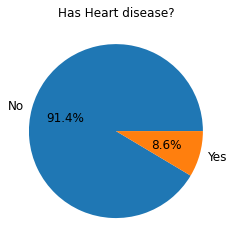

In [19]:
df.heartdisease.value_counts().plot(kind='pie', autopct='%.1f%%', textprops= {'size':12})
plt.ylabel('')
plt.title('Has Heart disease?')
plt.show()

Text(0.5, 1.0, 'BMI vs Heart Disease')

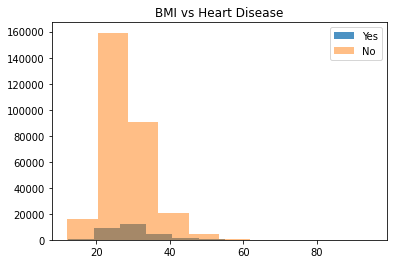

In [30]:
plt.hist(df.bmi[df.heartdisease=='Yes'], label='Yes',alpha= 0.8)
plt.hist(df.bmi[df.heartdisease=='No'], label='No', alpha=0.5)
plt.legend()
plt.title('BMI vs Heart Disease')

Text(0.5, 1.0, 'BMI')

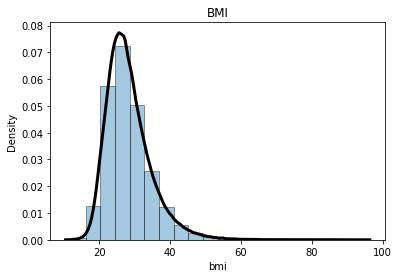

In [39]:
sns.distplot(df.bmi, bins=20, hist_kws= {'edgecolor':'black'}, kde_kws= {'lw':3, 'color':'black'})
plt.title('BMI')

(25.0, 30.0)

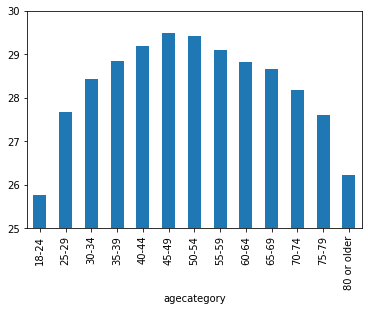

In [59]:
df.groupby('agecategory').bmi.mean().plot(kind='bar')
plt.ylim(25,30)

<AxesSubplot:xlabel='heartdisease', ylabel='smoking'>

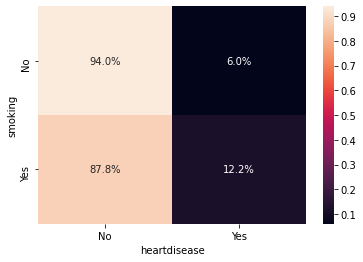

In [74]:
sns.heatmap(pd.crosstab(df.smoking, df.heartdisease, normalize='index'), annot=True, fmt='.1%')

In [78]:
pd.crosstab(df.stroke,df.heartdisease, normalize='columns')

heartdisease,No,Yes
stroke,,
No,0.973737,0.83966
Yes,0.026263,0.16034


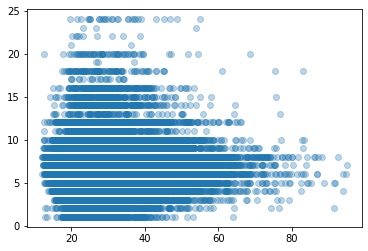

In [82]:
plt.scatter(df.bmi, df.sleeptime, alpha=0.3)

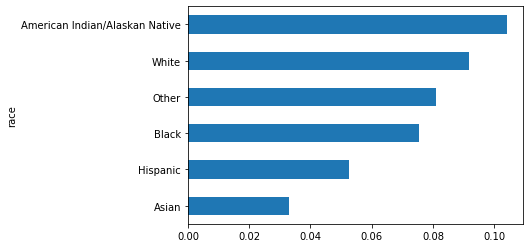

In [94]:
df.groupby('race').heartdisease.value_counts(normalize=True).unstack()['Yes'].sort_values().plot(kind='barh')
plt.show()

## Prediction

In [5]:
def find_outliers(series):
    q1= series.quantile(0.25)
    q3= series.quantile(0.75)
    iqr= q3-q1
    li= q1 - (1.5*iqr)
    ri= q3 + (1.5*iqr)
    return (series < li) | (series > ri)

In [51]:
class CustomEncoder:
    def __init__(self, columns=None):
        self.columns= columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        from sklearn.preprocessing import LabelEncoder
        if self.columns is not None:
            X[self.columns]= X[self.columns].apply(LabelEncoder().fit_transform)
        else:
            X= X.apply(LabelEncoder().fit_transform)
        return X
    
    def fit_transform(self, X,y=None):
        return self.fit(X).transform(X)

In [175]:
def body_type(x):
    if x <= 18.5: return 'Underweight'
    elif (x > 18.5) & (x <= 24.9): return 'Healthy weight'
    elif (x >= 25) & (x <= 29): return 'Overweight'
    elif (x >= 29.1) & (x <= 35): return 'Obese'
    else: return 'Extremely obese'

In [674]:
dummy= df.copy()
dummy= CustomEncoder(columns= dummy.select_dtypes('O').columns).fit_transform(dummy)
dummy.head(3)

,heartdisease,bmi,smoking,alcoholdrinking,stroke,physicalhealth,mentalhealth,diffwalking,sex,agecategory,race,diabetic,physicalactivity,genhealth,sleeptime,asthma,kidneydisease,skincancer
0,0,16.60,1,0,0,3.0,30.0,0,0,7,5,2,1,4,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,0,12,5,0,1,4,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,1,9,5,2,1,1,8.0,1,0,0


<AxesSubplot:>

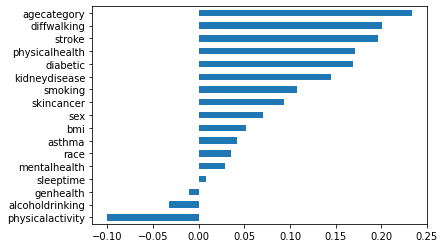

In [443]:
corr= dummy.corr()
corr['heartdisease'].drop('heartdisease').sort_values().plot(kind='barh')

In [545]:
from sklearn import metrics as mt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, learning_curve, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import time

In [744]:
X= df.drop('heartdisease', axis=1)
y= df.heartdisease.map({'Yes':1, 'No':0})

In [745]:
import pickle
with open('df.pkl' ,'wb') as ref:
    pickle.dump(X, ref) 

In [717]:
# Removing outliers from bmi
y= y[~find_outliers(X.bmi)]
X= X[~find_outliers(X.bmi)]

X.mentalhealth= np.log(X.mentalhealth)
X.mentalhealth.where(X.mentalhealth != -np.inf, 0, inplace=True)

X.physicalhealth= np.log(X.physicalhealth)
X.physicalhealth.where(X.physicalhealth != -np.inf, 0, inplace=True)

# cols_to_drop= ['race','asthma']
# X.drop(columns=cols_to_drop, axis=1, inplace=True)
X= pd.get_dummies(X, columns= ['race','genhealth','agecategory'], drop_first=True)

In [718]:
ruf= RandomUnderSampler()
X1,y1= ruf.fit_resample(X,y)

In [719]:
X_train, X_test, y_train, y_test= train_test_split(X1, y1, test_size=.20, stratify= X1['stroke'])

In [458]:
model_dict= {'Logistic Regression': LogisticRegression(),
            'K-Nearest neighbors': KNeighborsClassifier(),
            'Decision Tree': DecisionTreeClassifier(),
            'Random Forest': RandomForestClassifier(),
            'Ada Boost': AdaBoostClassifier(),
            'Gradient Boost': GradientBoostingClassifier()}

In [540]:
def train_multiple_models(model_dict,X,y,scoring,cv=3):
    from tqdm import tqdm
    scores= pd.DataFrame()
    for name, est in tqdm(model_dict.items()):
        steps= [('le',CustomEncoder(columns= X.select_dtypes('O').columns)), ('sc', StandardScaler()),  ('estimator',est)]
        pipe= Pipeline(steps= steps)
        cv_scores= cross_validate(estimator=pipe, X= X, y=y, cv= cv, return_train_score=True,scoring=scoring)
        cv_scores= pd.DataFrame(cv_scores)
        cv_scores['estimator']= name
        scores= scores.append(cv_scores, ignore_index=True)
    return scores

In [332]:
# multiple_model_scores= train_multiple_models(model_dict=model_dict, X=X_train, y= y_train,cv=3, scoring=['recall','precision','accuracy'])
# multiple_model_scores.groupby('estimator').train_accuracy.mean().sort_values().plot(marker='o', markersize= 10, lw=3, label='Train')
# multiple_model_scores.groupby('estimator').test_accuracy.mean().sort_values().plot(marker='o', markersize= 10, lw=3, label='Test')
# plt.xticks(rotation= 90)
# plt.legend()
# plt.title('Evaluation metrics for multiple models')
# plt.show()

In [738]:
steps= [('le',CustomEncoder(columns= X.select_dtypes('O').columns)), ('sc', StandardScaler()), 
        ('estimator',CatBoostClassifier(silent=True, learning_rate=0.01, l2_leaf_reg=3,max_depth= 7,
                                        n_estimators= 500, border_count= 64,od_type='Iter', od_wait=2,
                                        random_strength=0.70))]
pipe= Pipeline(steps= steps)

start= time.time()
pipe.fit(X_train, y_train)
end= time.time()
print('Model trained successfully in %.3f second(s).'%(end-start))

Model trained successfully in 21.048 second(s).


In [739]:
# Predictions for training and test set
pred_train, pred_test= pipe.predict(X_train),pipe.predict(X_test)
print(f'Training Recall: {mt.recall_score(y_train, pred_train):.2%} & Precision: {mt.precision_score(y_train, pred_train):.2%}')
print(f'Test Recall: {mt.recall_score(y_test, pred_test):.2%} & Precision: {mt.precision_score(y_test, pred_test):.2%}')

print(f'Training F1-score: {mt.f1_score(y_train, pred_train):.2f}')
print(f'Test F1-score: {mt.f1_score(y_test, pred_test):.2f}')

Training Recall: 78.29% & Precision: 75.88%
Test Recall: 78.02% & Precision: 75.69%
Training F1-score: 0.77
Test F1-score: 0.77


<AxesSubplot:>

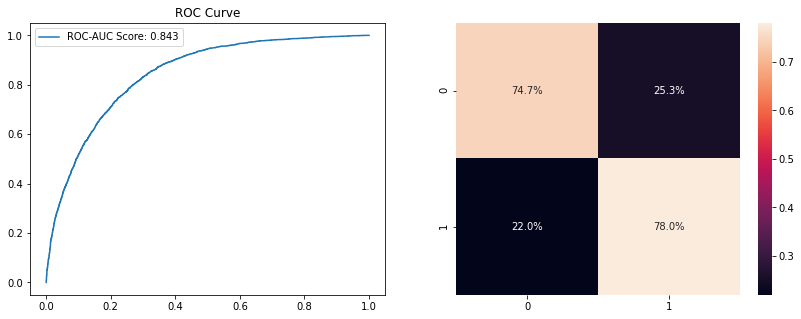

In [740]:
pred_prob= pipe.predict_proba(X_test)[:,1]
fpr, tpr, thresholds= mt.roc_curve(y_test, pred_prob)

pred= pipe.predict(X[:100])
conf_matrix= mt.confusion_matrix(y_test, pred_test).astype(float)
conf_matrix[0,:]= conf_matrix[0,:]/conf_matrix[0,:].sum()
conf_matrix[1,:]= conf_matrix[1,:]/conf_matrix[1,:].sum()

plt.figure(figsize= (14,5))
plt.subplot(121)
plt.plot(fpr, tpr, label= 'ROC-AUC Score: %.3f'%(mt.roc_auc_score(y_test, pred_prob)))
plt.legend()
plt.title('ROC Curve')


plt.subplot(122)
sns.heatmap(conf_matrix, annot=True, fmt='.1%')

In [742]:
import pickle
with open('model.pkl' ,'wb') as ref:
    pickle.dump(pipe, ref) 

In [761]:
import streamlit as st

In [766]:
st.set_page_config?

Signature:
st.set_page_config(
    page_title=None,
    page_icon=None,
    layout='centered',
    initial_sidebar_state='auto',
    menu_items=None,
)
Docstring:
Configures the default settings of the page.

.. note::
    This must be the first Streamlit command used in your app, and must only
    be set once.

Parameters
----------
page_title: str or None
    The page title, shown in the browser tab. If None, defaults to the
    filename of the script ("app.py" would show "app • Streamlit").
page_icon : Anything supported by st.image or str or None
    The page favicon.
    Besides the types supported by `st.image` (like URLs or numpy arrays),
    you can pass in an emoji as a string ("🦈") or a shortcode (":shark:").
    If you're feeling lucky, try "random" for a random emoji!
    Emoji icons are courtesy of Twemoji and loaded from MaxCDN.
layout: "centered" or "wide"
    How the page content should be laid out. Defaults to "centered",
    which constrains the elements into a center